It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ezponda/intro_deep_learning/blob/main/class/Fundamentals/NN_Fundamentals.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ezponda/intro_deep_learning/blob/main/class/Fundamentals/NN_Fundamentals.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib inline

tf.random.set_seed(0)

In [2]:

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap=plt.cm.Spectral)
    
def load_planar_dataset(m, sigma=0.2):
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*sigma # theta
        r = a*np.sin(4*t) + np.random.randn(N)*sigma # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    ## premuting ouput
    p = np.random.permutation(m)
    X = X[p,:]
    Y = Y[p,:]

    return X, Y.ravel()

def draw_neural_net(left, right, bottom, top, layer_sizes):
    '''
    From https://gist.github.com/craffel/2d727968c3aaebd10359#file-draw_neural_net-py
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    fig = plt.figure(figsize=(3, 3))
    ax = fig.gca()
    ax.axis('off')

    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

## Dataset 

We have a binary classification dataset. The target `y` has two possible values, {0,1} and the input vector `x` has two dimensions.

In [3]:
N = 5000
X, y = load_planar_dataset(N, 0.2)

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data. 

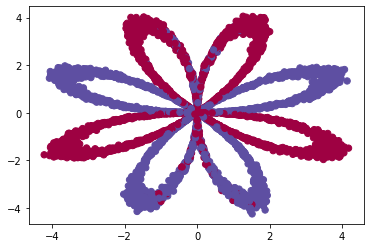

In [4]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [5]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.2,
)

In [6]:
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(4000, 2), y_train shape:(4000,)
X_test shape:(1000, 2), y_test shape:(1000,)


In [ ]:
## X first example
X[0,:]

In [8]:
## Y firsts examples
y[:8]

array([0, 0, 1, 0, 0, 0, 1, 1], dtype=uint8)

## First NN in Keras

### Logistic regression

Fully connected layers are defined using the [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class. We can specify the number of neurons as the first argument, and specify the activation function using the activation argument.

```python
tf.keras.layers.Dense(
    units, activation=None
)

```

- **units**: Number of neurons in the layer.
- **activation**: Activation function to use, default function is `linear`, you can also use `sigmoid` for sigmoid activation or [other alternatives](https://www.tensorflow.org/api_docs/python/tf/keras/activations) 

For defining the input layer you can use `keras.Input(shape=(input_dimension,))` or define your input dimension in the first hidden layer.

```python
layers.Dense(4, activation="sigmoid", input_shape=(input_dimension,))

```

Build a network without hidden layer

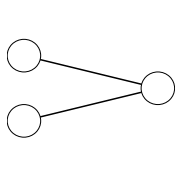

In [9]:
draw_neural_net(.1, .9, .1, .9, [2, 1])

In [10]:
model = keras.Sequential()
# The dimension of the input is 2 (planar data)
# we have only one output layer with 1 neuron
model.add(keras.layers.Dense(1, input_shape=(2, ), activation='sigmoid')) # 1 neurona

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


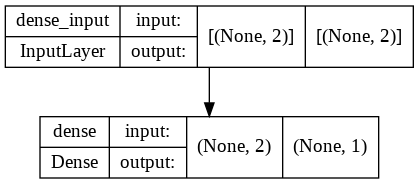

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

#### Compile
Now we need to specify the loss function, the metrics and the optimizer. It is done using compile function in Keras.

In [13]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#### Training model
This is similar to a sklearn model.

In [14]:
model.fit(X_train, y_train, epochs=10,
          validation_split=0.2, batch_size=32)

Epoch 1/10
100/100 [==============================] - 4s 4ms/step - loss: 0.8770 - accuracy: 0.6256 - val_loss: 0.8027 - val_accuracy: 0.6438
Epoch 2/10
100/100 [==============================] - 0s 3ms/step - loss: 0.8227 - accuracy: 0.6212 - val_loss: 0.7602 - val_accuracy: 0.6388
Epoch 3/10
100/100 [==============================] - 0s 3ms/step - loss: 0.7772 - accuracy: 0.6147 - val_loss: 0.7262 - val_accuracy: 0.6325
Epoch 4/10
100/100 [==============================] - 0s 2ms/step - loss: 0.7405 - accuracy: 0.6025 - val_loss: 0.7006 - val_accuracy: 0.6237
Epoch 5/10
100/100 [==============================] - 0s 3ms/step - loss: 0.7128 - accuracy: 0.5888 - val_loss: 0.6830 - val_accuracy: 0.6062
Epoch 6/10
100/100 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5700 - val_loss: 0.6713 - val_accuracy: 0.5788
Epoch 7/10
100/100 [==============================] - 0s 2ms/step - loss: 0.6806 - accuracy: 0.5472 - val_loss: 0.6647 - val_accuracy: 0.5650
Epoch 

#### Making predictions

In [15]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.6474943161010742
Test Accuracy: 0.503000020980835


In [ ]:
y_pred = model.predict(X_test)
y_pred[:3], y_test[:3]

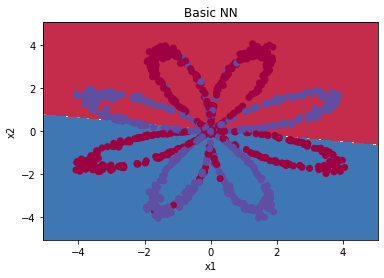

In [17]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("Basic NN");

### One hidden layer NN

- One **input with 2 features (input_shape)**
- **One hidden dense layer**,  with **3 neurons** and implemented with  **sigmoid activating function**
- **One Output** (sigmoid output activation function)

We can create layers incrementally with the method `add()`:

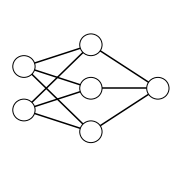

In [18]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 1])

In [19]:
model = keras.Sequential()

## hidden layer with 3 neurons and sigmoid activation
## The first layer need to have the input_shape
model.add(layers.Dense(3, input_shape=(2,), activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

## model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3)                 9         
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


You can also define the model with a list of layers
```python
model = keras.Sequential([
    keras.Input(shape=(2, )),
    layers.Dense(3, activation='sigmoid', name='layer1'),
    layers.Dense(1, activation='sigmoid', name='layer3')
])
````

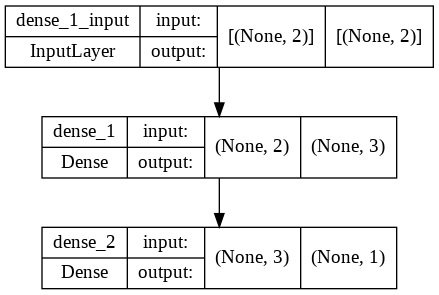

In [20]:
plot_model(model, show_shapes=True)

In [21]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 1s 4ms/step - loss: 0.6938 - accuracy: 0.5972 - val_loss: 0.6848 - val_accuracy: 0.6313
Epoch 2/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6894 - accuracy: 0.6172 - val_loss: 0.6820 - val_accuracy: 0.6587
Epoch 3/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.6259 - val_loss: 0.6788 - val_accuracy: 0.6212
Epoch 4/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5753 - val_loss: 0.6757 - val_accuracy: 0.5663
Epoch 5/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.5331 - val_loss: 0.6720 - val_accuracy: 0.5300
Epoch 6/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6738 - accuracy: 0.4963 - val_loss: 0.6690 - val_accuracy: 0.5000
Epoch 7/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6700 - accuracy: 0.4844 - val_loss: 0.6662 - val_accuracy: 0.5000
Epoch 

In [22]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.598361611366272
Test Accuracy: 0.5720000267028809


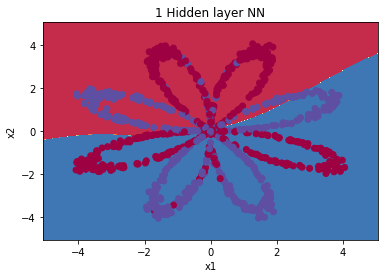

In [23]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN");

### Question 1:
####  What happens if we change the activation function of the first hidden  layer to `'linear'`? 

In [26]:
model = keras.Sequential()
## The first layer need to have the input_shape
## change the activation function
model.add(layers.Dense(3, input_shape=(2,), activation='linear'))
# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [27]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 1s 7ms/step - loss: 1.4264 - accuracy: 0.3750 - val_loss: 1.2752 - val_accuracy: 0.3575
Epoch 2/25
100/100 [==============================] - 0s 4ms/step - loss: 1.1339 - accuracy: 0.3728 - val_loss: 1.0207 - val_accuracy: 0.3475
Epoch 3/25
100/100 [==============================] - 0s 3ms/step - loss: 0.9136 - accuracy: 0.3606 - val_loss: 0.8413 - val_accuracy: 0.3338
Epoch 4/25
100/100 [==============================] - 0s 3ms/step - loss: 0.7753 - accuracy: 0.3519 - val_loss: 0.7400 - val_accuracy: 0.3375
Epoch 5/25
100/100 [==============================] - 0s 3ms/step - loss: 0.7095 - accuracy: 0.4269 - val_loss: 0.6933 - val_accuracy: 0.5188
Epoch 6/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6828 - accuracy: 0.5725 - val_loss: 0.6747 - val_accuracy: 0.5325
Epoch 7/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6717 - accuracy: 0.4794 - val_loss: 0.6671 - val_accuracy: 0.4800
Epoch 

Test Loss: 0.6485507488250732
Test Accuracy: 0.4819999933242798


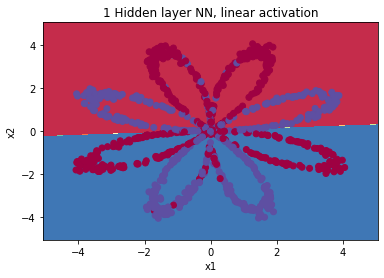

In [28]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

### Question 2:
####  What happens if we add more neurons to the first hidden layer ? 

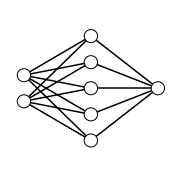

In [29]:
draw_neural_net(.1, .9, .1, .9, [2, 5, 1])

In [30]:
model = keras.Sequential()

## The first layer need to have the input_shape
## set the number of neurons
model.add(layers.Dense(5, input_shape=(2,), activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [31]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 1s 4ms/step - loss: 0.8930 - accuracy: 0.5191 - val_loss: 0.8174 - val_accuracy: 0.5575
Epoch 2/25
100/100 [==============================] - 0s 3ms/step - loss: 0.8087 - accuracy: 0.5194 - val_loss: 0.7589 - val_accuracy: 0.5400
Epoch 3/25
100/100 [==============================] - 0s 3ms/step - loss: 0.7548 - accuracy: 0.4762 - val_loss: 0.7221 - val_accuracy: 0.4913
Epoch 4/25
100/100 [==============================] - 0s 3ms/step - loss: 0.7196 - accuracy: 0.4881 - val_loss: 0.6973 - val_accuracy: 0.5638
Epoch 5/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.5516 - val_loss: 0.6804 - val_accuracy: 0.5775
Epoch 6/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.5694 - val_loss: 0.6691 - val_accuracy: 0.6187
Epoch 7/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.5519 - val_loss: 0.6613 - val_accuracy: 0.5575
Epoch 

Test Loss: 0.5682059526443481
Test Accuracy: 0.7289999723434448


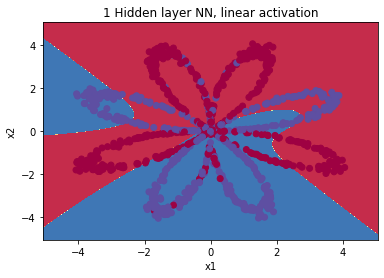

In [32]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

### Question 3:
####  What happens if we add one more hidden layer ? 

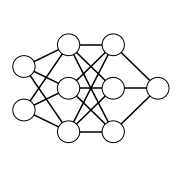

In [33]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 3, 1])

In [34]:
model = keras.Sequential()
# First hidden layer (need to innclude input_shape)
## Set the number of neurons
model.add(layers.Dense(3, input_shape=(2,), activation='sigmoid'))

# second hidden layer
## Complete the code
model.add(layers.Dense(3, activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [35]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 1s 4ms/step - loss: 0.7915 - accuracy: 0.4969 - val_loss: 0.7410 - val_accuracy: 0.5200
Epoch 2/25
100/100 [==============================] - 0s 3ms/step - loss: 0.7358 - accuracy: 0.4969 - val_loss: 0.7066 - val_accuracy: 0.5200
Epoch 3/25
100/100 [==============================] - 0s 3ms/step - loss: 0.7071 - accuracy: 0.4969 - val_loss: 0.6904 - val_accuracy: 0.5200
Epoch 4/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.4969 - val_loss: 0.6826 - val_accuracy: 0.5200
Epoch 5/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6847 - accuracy: 0.4969 - val_loss: 0.6789 - val_accuracy: 0.5200
Epoch 6/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6803 - accuracy: 0.5766 - val_loss: 0.6767 - val_accuracy: 0.6363
Epoch 7/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6772 - accuracy: 0.5813 - val_loss: 0.6749 - val_accuracy: 0.6000
Epoch 

Test Loss: 0.5891669392585754
Test Accuracy: 0.6549999713897705


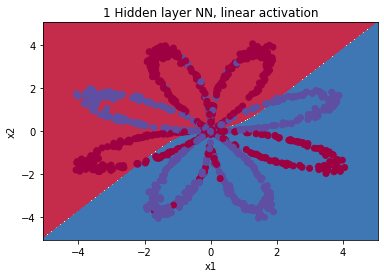

In [36]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

####  Use  the [hyperbolic tangent](https://mathworld.wolfram.com/HyperbolicTangent.html) activation `'tanh'` with the first simple model and compare the results with the sigmoid activation

In [37]:
model = keras.Sequential()
## The first layer need to have the input_shape
## change the activation function
model.add(layers.Dense(3, input_shape=(2,), activation='tanh'))
# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [38]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 1s 4ms/step - loss: 0.8243 - accuracy: 0.4137 - val_loss: 0.7929 - val_accuracy: 0.3812
Epoch 2/25
100/100 [==============================] - 0s 3ms/step - loss: 0.7559 - accuracy: 0.4166 - val_loss: 0.7336 - val_accuracy: 0.3812
Epoch 3/25
100/100 [==============================] - 0s 3ms/step - loss: 0.7040 - accuracy: 0.5091 - val_loss: 0.6922 - val_accuracy: 0.5100
Epoch 4/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6702 - accuracy: 0.5316 - val_loss: 0.6653 - val_accuracy: 0.4812
Epoch 5/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6485 - accuracy: 0.5656 - val_loss: 0.6474 - val_accuracy: 0.6275
Epoch 6/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6422 - val_loss: 0.6358 - val_accuracy: 0.6313
Epoch 7/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.6441 - val_loss: 0.6273 - val_accuracy: 0.6313
Epoch 

Test Loss: 0.4016290307044983
Test Accuracy: 0.8980000019073486


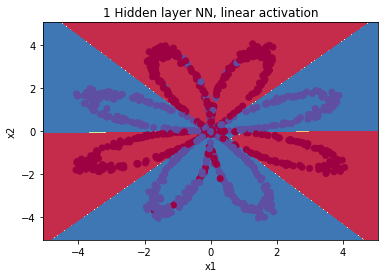

In [39]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

## Practice I

Repeat the process with a different dataset.

In [40]:
N = 5000
X, y = sklearn.datasets.make_moons(n_samples=N, noise=.18)

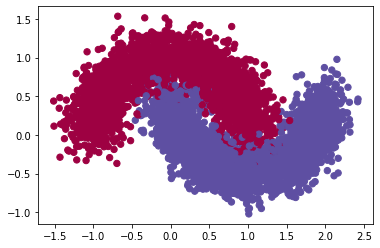

In [41]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [42]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(3750, 2), y_train shape:(3750,)
X_test shape:(1250, 2), y_test shape:(1250,)


### Define your model

In [ ]:
model = keras.Sequential()
## The first layer need to have the input_shape
model.add(layers...(..., input_shape=(...,), activation=...))

## Second Layer, don't use input_shape
model...(...)

# output layer
model.add(layers.Dense(..., activation=...))

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)

## Functional API

The Keras Functional API allows defining the topology of the models as a [acyclic directed graph](https://en.wikipedia.org/wiki/Directed_acyclic_graph) of layers. Next we will build the same model as in the previous section but using the Keras Functional API.

You need to start with an input data entry:
```python    
    inputs = keras.Input(shape=(8,))
```
    
We define the layers that we will include in the network and the relationships between them. It is important to note that each line details the type of layer and its properties (number of neurons, activation function, name ...) and just at the end, in parentheses, the name of the variable in which we have saved the layer from which its output will connect to the input of the layer we are declaring.
```python
layer_1 = layers.Dense(4, activation='sigmoid',
                       name='layer_1')(inputs)
layer_2 = layers.Dense(4, activation='sigmoid',
                       name='layer_2')(layer_1)
```

The "layer call" `Dense()(inputs)` action is like drawing an arrow from "inputs" to this layer you created. You're "passing" the inputs to the dense layer, and you get `layer_1` as the output.

  

Finally, we define the network outputs:
```python
outputs = layers.Dense(1, name='output_layer')(layer_2)
```

We create the model specifying the inputs and outputs:
```python
model = keras.Model(inputs=inputs, outputs=outputs)
```

In [ ]:
draw_neural_net(.1, .9, .1, .9, [8, 4, 4, 1])

In [ ]:
inputs = keras.Input(shape=(8, ), name='input_layer')
l_1 = layers.Dense(4, activation='relu', name='layer_1')(inputs)
l_2 = layers.Dense(4, activation='relu', name='layer_2')(l_1)
outputs = layers.Dense(1, name='output_layer')(l_2)

model = keras.Model(inputs=inputs, outputs=outputs, name='example_model')

model.summary()

In [ ]:
plot_model(model, show_shapes=True)

## Practice II

Repeat the process with a different dataset and the **Functional API**

In [ ]:
N = 5000
X, y = sklearn.datasets.make_circles(n_samples=N, factor=.65, noise=.065) # sklearn.datasets.make_moons(n_samples=N, noise=.15)

In [ ]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

### Define your model

In [ ]:
inputs = keras.Input(shape=(2, ), name='input_layer')
## First hidden layer
l_1 = layers.Dense(...)(inputs)
...

## output layer
outputs = layers.Dense(...
                       

model = keras.Model(inputs=inputs,...

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)